In [3]:
import os
#import numpy as np
import sys
import glob
import re
import h5py

### keras / tensorflow not used
#os.environ['KERAS_BACKEND'] = 'tensorflow'
#os.environ['CUDA_VISIBLE_DEVICES'] = '6'

if __package__ is None:
    sys.path.append(os.path.realpath("/data/shared/Software/CMS_Deep_Learning"))
    
from CMS_Deep_Learning.io import gen_from_data, retrieve_data, simple_grab
from CMS_Deep_Learning.postprocessing.metrics import distribute_to_bins


if __package__ is None:
    sys.path.append(os.path.realpath("/data/shared/Software/RegressionLCD"))
    
from model import *
from preprocessing import *
from postprocessing import *

Using TensorFlow backend.


In [2]:
!pwd

/nfshome/vitoriabp/gpu-4-culture-plate-sm/CaloImage_DNN


Getting true values and prediction data for each particle:

In [4]:
gammaTruePred = true_pred_from_HDF5("GammaTruePred") # These are the predictions saved to an HDF5 file
eleTruePred = true_pred_from_HDF5("EleTruePred")
pi0TruePred = true_pred_from_HDF5("Pi0TruePred")
chPiTruePred = true_pred_from_HDF5("ChPiTruePred")

gamma_true = gammaTruePred[0]
gamma_pred = gammaTruePred[1]

ele_true = eleTruePred[0]
ele_pred = eleTruePred[1]

pi0_true = pi0TruePred[0]
pi0_pred = pi0TruePred[1]

chPi_true = chPiTruePred[0]
chPi_pred = chPiTruePred[1]

Binning for the DNN:

In [5]:
nbins = 10
x_gamma, y_gamma, means_gamma, rMeans_gamma, stds_gamma, rStds_gamma, sizes_gamma, res_gamma = binning(
        nbins, gamma_true, gamma_pred)
x_ele, y_ele, means_ele, rMeans_ele, stds_ele, rStds_ele, sizes_ele, res_ele = binning(nbins, ele_true, ele_pred)
x_pi0, y_pi0, means_pi0, rMeans_pi0, stds_pi0, rStds_pi0, sizes_pi0, res_pi0 = binning(nbins, pi0_true, pi0_pred)
x_chPi, y_chPi, means_chPi, rMeans_chPi, stds_chPi, rStds_chPi, sizes_chPi, res_chPi = binning(nbins, chPi_true, chPi_pred)

In [5]:
print len(x_gamma)
for i in range(len(x_gamma)): print x_gamma[i].min(),x_gamma[i].mean(),x_gamma[i].max()

10
10.000113 34.4617051165 58.79917
58.800069 83.5231890148 108.054833
108.055684 132.458641002 156.910895
156.915463 181.629230813 206.30438
206.304536 230.989508513 255.450573
255.452637 280.103753374 304.320547
304.326756 328.800548341 353.228191
353.22951 377.687598251 402.117995
402.119564 426.576279832 450.860894
450.861182 475.566841852 509.735295


Linear fit and binning:

In [6]:
def findAB(the_target, E_summed, H_summed):
    m = None
    sol = None

    for A in np.linspace(40, 150, 500):
        for B in np.linspace(40, 150, 500):
            res = (the_target - (A*E_summed + B*H_summed))**2
            r = res.mean()
        
            if m == None or r < m:
                m = r
                sol = A, B
                #print sol
    return sol

In [7]:
def lin_bins(A, B, the_target, E_summed, H_summed, nbins=10):
    '''
    Returns bins and res arrays to be plotted.
    '''
    min_E = 10
    max_E = 500
    Elow = float(min_E)
    bins = []
    res = []
    size = []
    for Eup in np.linspace(10, 500, nbins+1):
        if not Eup or Elow == Eup: continue
    
        #### DO: shouldn't there also be an upper bound on the energy for each bin?
        E_bin_old = np.where((the_target > Elow))
        E_bin = np.where((the_target > Elow) & (the_target <= Eup))
        content = (the_target - (A*E_summed + B*H_summed))[E_bin]
        #### DO: should divide by energy of each object, instead of avgE at the end,
        ####     to be more correct.  more relevant the wider bins get 
        rdif = 100.*content / the_target[E_bin]
#        content = (the_target - (A*E_summed + B*H_summed))[E_bin_old]
#        rdif = 100.*content / the_target[E_bin_old]
        meandif = content.mean()
        rms2 = rdif.std()
        rms = content.std()
        size.append(len(content))
        E = (Eup + Elow) / 2.
        #print E,the_target[E_bin_old].mean(),the_target[E_bin].mean()
        #print meandif,meandif/E,(100*rms/E),rms2
        bins.append(E)
        #res.append(100*rms/E)
        res.append(rms2)
        me = content.mean()
    
        Elow = Eup
        
    return bins, res, size

In [8]:
def returnBinsRes(directory):
    GammaEscan = h5py.File(directory, "r")
    gamma_E_sum = GammaEscan['ECAL'].value.sum( axis = (1,2,3))
    gamma_H_sum = GammaEscan['HCAL'].value.sum( axis = (1,2,3))
    gamma_target = np.array(GammaEscan["target"], dtype = "float32")
    gamma_target = gamma_target[:,1]

    gamma_a, gamma_b = findAB(gamma_target, gamma_E_sum, gamma_H_sum)
    print gamma_a, gamma_b
    gamma_bins, gamma_res, sizes = lin_bins(gamma_a, gamma_b, gamma_target, gamma_E_sum, gamma_H_sum)
    return gamma_bins, gamma_res, sizes

In [9]:
def func(E, a, b, c):
    # equation to be fit in the data
    #return a / np.sqrt(E) + b + c / E
    return np.sqrt((a**2 / E) + b**2 + (c / E)**2)

In [10]:
# Linear fit for Gamma:
gamma_bins, gamma_res, gamma_size = returnBinsRes("/bigdata/shared/LCD/V1/GammaEscan/test/GammaEscan_2_1.h5")


49.6993987976 111.643286573


In [11]:
# a, b, c for Gamma:
#### DO: why divide by sqrt(2*N) instead of sqrt(N) ?
gamma_popt, pcov = curve_fit(func, gamma_bins, gamma_res, sigma= gamma_res / np.sqrt(2*np.asarray(gamma_size))
                             ,bounds=(0,100000000))
print(gamma_popt)

# if you want to check that the fit is OK:
#y_gamma = func(gamma_bins, *gamma_popt)
#plt.plot(gamma_bins, y_gamma, 'r')
#plt.scatter(gamma_bins, gamma_res)
#plt.show()

[  8.54919203e-07   4.13295942e+00   3.27064720e+02]


In [12]:
# Linear fit for Ele:
ele_bins, ele_res, ele_size = returnBinsRes("/bigdata/shared/LCD/V1/EleEscan/test/EleEscan_2_1.h5")

48.8176352705 112.745490982


In [13]:
# a, b, c for Ele:
ele_popt, pcov = curve_fit(func, ele_bins, ele_res, sigma= ele_res / np.sqrt(2*np.asarray(ele_size ))
                                                                               , bounds=(0,100000000))

print(ele_popt)

[  23.41571222    3.11840272  246.81697324]


In [14]:
# Linear fit for Pi0:
pi0_bins, pi0_res, pi0_size = returnBinsRes("/bigdata/shared/LCD/V1/Pi0Escan/test/Pi0Escan_2_1.h5")

# a, b, c for Pi0:
pi0_popt, pcov = curve_fit(func, pi0_bins, pi0_res, 
                           sigma= pi0_res / np.sqrt(2*np.asarray(pi0_size)), 
                           bounds=(0,100000000))
print(pi0_popt)

49.4789579158 102.825651303
[  15.3982885     3.78924922  422.67385642]


In [16]:
import numpy as np

In [17]:
ChPi = h5py.File("/bigdata/shared/LCD/V1/ChPiEscan/_ChPiEscan/test/ChPiEscan_2_1.h5", "r")

chPi_E_sum = ChPi['good_ECAL'].value.sum( axis = (1,2,3))
chPi_H_sum = ChPi['good_HCAL'].value.sum( axis = (1,2,3))

chPi_target = np.array(ChPi["good_target"], dtype = "float32")
chPi_target = chPi_target[:,1]

In [18]:
chPi_E_sum = ChPi['good_ECAL'].value.sum( axis = (1,2,3))

In [22]:
type(chPi_E_sum)

numpy.ndarray

In [23]:
chPi_H_sum

array([ 1.72190276,  3.75888027,  9.38118412, ...,  1.42276937,
        3.45525148,  1.42684163])

In [27]:
chPi_a, chPi_b = findAB(chPi_target, chPi_E_sum, chPi_H_sum)

In [30]:
chPi_bins, chPi_res, s = lin_bins(chPi_a, chPi_b, chPi_target, chPi_E_sum, chPi_H_sum)

In [33]:
import matplotlib.pyplot as plt

In [34]:
%matplotlib inline

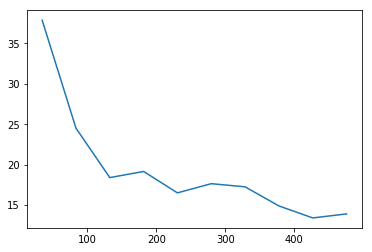

In [35]:
plt.plot(chPi_bins, chPi_res)

Code for the final plot:

In [36]:
def fit_part(func, energies, res, sigmas=None, verbose=False):
    popt, pcov = curve_fit(func, energies, res,
                           bounds=(0,1000),
                            sigma=sigmas,
                          #method='trf'
                          )
    if (verbose == True):
        print(popt)
        # print(pcov)
    return popt

In [37]:
def aux_stds(stds, label="", marker='.', col='black'):
    '''
    Single particle stds auxiliar.
    :param means: array containing the means to be plotted.
    :type means: array
    :param stds: stds array to calculate the error.
    :type stds: array
    :param sizes: array containing the number of samples in each bin, to calculate the error.
    :type sizes: array
    '''
    
    n = len(stds)
    iSize = (500-10)/n

    energies = []
    
    for i in range(0, n):
        x_axis = 10+(i * iSize + (i + 1) * iSize) / 2
        energies.append(x_axis)
    
    plt.scatter(energies, stds, marker=marker, color=col, alpha=0.5, label=label)
        
    return energies

In [44]:
def ultimate_plot(rStds_gamma, rStds_ele, rStds_pi0, rStds_chPi, bins_gamma, res_gamma, bins_ele, res_ele, bins_pi0, res_pi0, bins_chPi, res_chPi, str_title="", verbose=False):
    #from scipy.optimize import curve_fit
    plt.figure(figsize=(6, 6))

    ## plot the points ##
    energies_gamma = aux_stds(rStds_gamma, label="CNN: Photons", marker='o', col='green')
    energies_ele = aux_stds(rStds_ele, label="CNN: Electrons", marker='*', col='red')
    energies_pi0 = aux_stds(rStds_pi0, label="CNN: Neutral Pions", marker='s', col='blue')
    energies_chPi = aux_stds(rStds_chPi, label="CNN: Charged Pions", marker='^', col='orange')
    ## - ##

    ## fits ##
    plt.rcParams['agg.path.chunksize'] = 10000
    

    #gamma_popt = fit_part(bad_func, energies_gamma, rStds_gamma)
    #print gamma_popt
    #ele_popt = fit_part(bad_func, energies_ele, rStds_ele)
    #print ele_popt
    #pi0_popt = fit_part(bad_func, energies_pi0, rStds_pi0)
    #print pi0_popt
    #chPi_popt = fit_part(bad_func, energies_chPi, rStds_chPi)
    #print chPi_popt
    
    sig_rStds_gamma = rStds_gamma / np.sqrt(2*np.asarray(sizes_gamma))
    gamma_popt = fit_part(func, energies_gamma, rStds_gamma, sigmas= sig_rStds_gamma)
    print gamma_popt
    sig_rStds_ele = rStds_ele / np.sqrt(2*np.asarray(sizes_ele))
    ele_popt = fit_part(func, energies_ele, rStds_ele, sigmas = sig_rStds_ele)
    print ele_popt
    sig_rStds_pi0 = rStds_pi0 / np.sqrt(2*np.asarray(sizes_pi0))
    pi0_popt = fit_part(func, energies_pi0, rStds_pi0, sigmas = sig_rStds_pi0)
    print pi0_popt
    sig_rStds_chPi = rStds_chPi / np.sqrt(2*np.asarray(sizes_chPi))
    chPi_popt = fit_part(func, energies_chPi, rStds_chPi, sigmas = sig_rStds_chPi)
    print chPi_popt
    
    y_gamma = func(energies_gamma, *gamma_popt)
    y_ele = func(energies_ele, *ele_popt)
    y_pi0 = func(energies_pi0, *pi0_popt)
    y_chPi = func(energies_chPi, *chPi_popt)

    plt.plot(energies_gamma, y_gamma, color='green', ls="-")
    plt.plot(energies_ele, y_ele, color='red', ls="-")
    plt.plot(energies_pi0, y_pi0, color='blue', ls="-")
    plt.plot(energies_chPi, y_chPi, color='orange', ls="-")
    ## -- ##
    
    ## linear ##
    plt.plot(bins_gamma, res_gamma, color='green', ls=":", label="Linear fit: Photons", marker='o', markerfacecolor='None', alpha=0.5)
    plt.plot(bins_ele, res_ele, color='red', ls=":", label="Linear fit: Electrons", marker='*', markerfacecolor='None', alpha=0.5)
    plt.plot(bins_pi0, res_pi0, color='blue', ls=":", label="Linear fit: Neutral Pions", marker='s', markerfacecolor='None', alpha=0.5)
    plt.plot(chPi_bins, chPi_res, color='orange', ls=":", label="Linear fit: Charged Pions", marker='^', markerfacecolor='None', alpha=0.5)
    ## -- ##
    plt.yscale('log')
    plt.xlabel("True Energy (GeV)", size=18)
    plt.ylabel(r"$\frac{\sigma({\Delta E})}{E_{true}}$", size=21)
    plt.title("Energy resolution", size=18)
    plt.xlim(0, 500)
    #plt.ylim(0.5, 2000)
    plt.legend(
        bbox_to_anchor=(1, 1.1), prop={'size': 18}
    )
    plt.show()
    #plt.savefig("ultimate.png", dpi=1000,bbox_inches='tight')

[  13.56059536    0.90848929  195.3101272 ]
[  15.16343964    0.69869754  172.52354046]
[  2.08694880e-05   8.98752892e-01   3.25665064e+02]
[  1.15113478e+02   2.72039016e-10   1.00000000e+03]


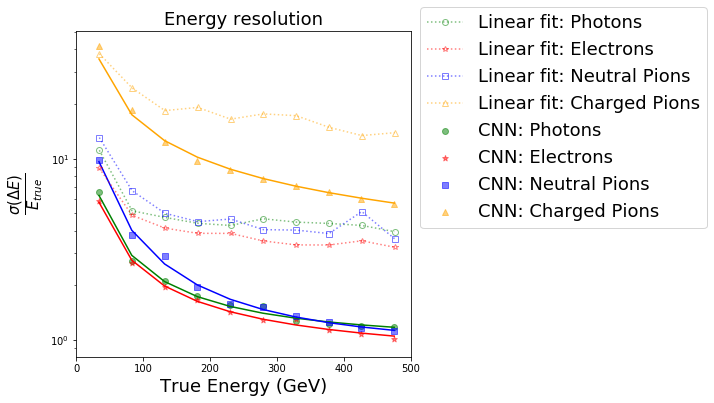

In [45]:
ultimate_plot(rStds_gamma, rStds_ele, rStds_pi0, rStds_chPi, gamma_bins, gamma_res, ele_bins, ele_res, pi0_bins, pi0_res, chPi_bins, chPi_res)

In [48]:
## To get the predictions for all the files!

# grab targets (y) for GammaEscan
test_dir = "/bigdata/shared/LCD/V1/GammaEscan/test/"

y_gamma = simple_grab('Y', data=test_dir, label_keys='target',
                        input_keys=['ECAL', 'HCAL'])
y_gamma = y_gamma[:, 1:]
y_gamma = y_gamma.ravel()

In [49]:
# grab values to input in the linear regression for GammaEscan
ecal, hcal = simple_grab('X', data=test_dir, label_keys=['ECAL', 'HCAL'], input_keys=['ECAL', 'HCAL'])

s_ecal = sumCal(ecal)
s_hcal = sumCal(hcal)

s_ecal = s_ecal.ravel()
s_hcal = s_hcal.ravel()

print s_ecal

print s_hcal

[ 3.05450194  6.9095479   8.95467217 ...,  3.47775073  0.46970158
  5.6702033 ]
[ 0.24333755  0.19483612  0.22780916 ...,  0.14785408  0.0097054
  0.15037942]


In [50]:
# grab targets (y) for EleEscan
test_dir = "/bigdata/shared/LCD/V1/EleEscan/test/"

y_ele = simple_grab('Y', data=test_dir, label_keys='target',
                        input_keys=['ECAL', 'HCAL'])
y_ele = y_ele[:, 1:]
y_ele = y_ele.ravel()

In [51]:
# grab values to input in the linear regression for EleEscan
ecal_ele, hcal_ele = simple_grab('X', data=test_dir, label_keys=['ECAL', 'HCAL'], input_keys=['ECAL', 'HCAL'])

s_ecal_ele = sumCal(ecal_ele)
s_hcal_ele = sumCal(hcal_ele)

s_ecal_ele = s_ecal_ele.ravel()
s_hcal_ele = s_hcal_ele.ravel()

print s_ecal_ele

print s_hcal_ele

[ 8.4796093   1.42956294  5.27279468 ...,  3.62874665  1.21420259
  5.18594228]
[ 0.44454447  0.01842831  0.21940319 ...,  0.05814127  0.02894732
  0.21202614]


In [1]:
def grab(direc):
    # grab targets (y) for EleEscan
    y_ele = simple_grab('Y', data=direc, label_keys='target',
                        input_keys=['ECAL', 'HCAL'])
    y_ele = y_ele[:, 1:]
    y_ele = y_ele.ravel()
    
    # grab and calculate values for regression model
    ecal_ele, hcal_ele = simple_grab('X', data=direc, label_keys=['ECAL', 'HCAL'], input_keys=['ECAL', 'HCAL'])

    s_ecal_ele = sumCal(ecal_ele)
    s_hcal_ele = sumCal(hcal_ele)

    s_ecal_ele = s_ecal_ele.ravel()
    s_hcal_ele = s_hcal_ele.ravel()

    return y_ele, s_ecal_ele, s_hcal_ele

In [2]:
y_pi0, s_ecal_pi0, s_hcal_pi0 = grab("/bigdata/shared/LCD/V1/Pi0Escan/test/")

NameError: global name 'simple_grab' is not defined

In [ ]:
def grab_ch(direc):
    # grab targets (y) for EleEscan
    y_ele = simple_grab('Y', data=direc, label_keys='good_target',
                        input_keys=['good_ECAL', 'good_HCAL'])
    y_ele = y_ele[:, 1:]
    y_ele = y_ele.ravel()
    
    # grab and calculate values for regression model
    ecal_ele, hcal_ele = simple_grab('X', data=direc, label_keys=['good_ECAL', 'good_HCAL'], input_keys=['good_ECAL', 'good_HCAL'])

    s_ecal_ele = sumCal(ecal_ele)
    s_hcal_ele = sumCal(hcal_ele)

    s_ecal_ele = s_ecal_ele.ravel()
    s_hcal_ele = s_hcal_ele.ravel()

    return y_ele, s_ecal_ele, s_hcal_ele

In [ ]:
y_chPi, s_ecal_chPi, s_hcal_chPi = grab("/bigdata/shared/LCD/V1/ChPiEscan/_ChPiEscan/test/")

In [ ]:
gamma_linpred = gamma_a*gamma_E_sum + gamma_b*gamma_H_sum

In [ ]:
out, x, y = distribute_to_bins(gamma_target, [gamma_target, gamma_linpred], nb_bins=nbins, equalBins=True)

In [ ]:
def simple_binning(nbins, label, pred):
    iSize = 500 / nbins

    means = []
    rMeans = []  # normalized means
    stds = []
    rStds = []  # normalized standard deviations
    sizes = []  # number of events in the bins
    
    for i in range(0, nbins):
        sizes.append(len(x[i]))

        #if (plot == True):
            #plotPredictedXTarget(x[i], y[i], i * iSize, (i + 1) * iSize)
        #PredictedTarget(x[i], y[i], i * iSize, (i + 1) * iSize)
            # histEDif(x[i], y[i], nbins=200, lim=20, lim_l=i*iSize, lim_r=(i+1)*iSize)
        #histRelDif(x[i], y[i], nbins=150, lim=15, lim_l=i*iSize, lim_r=(i+1)*iSize)

        difference = dif(x[i], y[i])
        relDiff = rDif(x[i], y[i])

        mean = np.mean(difference)
        means.append(mean)

        rMean = np.mean(relDiff)
        rMeans.append(rMean)

        std = np.std(difference)
        stds.append(std)

        rStd = np.std(relDiff)
        rStds.append(rStd)
        
        return x, y, means, rMeans, stds, rStds, sizes

In [ ]:
nbins = 10
x_gamma, y_gamma, means_gamma, rMeans_gamma, stds_gamma, rStds_gamma, sizes_gamma = simple_binning(
        nbins, gamma_true, gamma_pred)
x_ele, y_ele, means_ele, rMeans_ele, stds_ele, rStds_ele, sizes_ele = simple_binning(nbins, ele_true, ele_pred)
x_pi0, y_pi0, means_pi0, rMeans_pi0, stds_pi0, rStds_pi0, sizes_pi0 = simple_binning(nbins, pi0_true, pi0_pred)
x_chPi, y_chPi, means_chPi, rMeans_chPi, stds_chPi, rStds_chPi, sizes_chPi = simple_binning(nbins, chPi_true, chPi_pred)